# Why is accuracy so low?

* Visualize misclassified examples: See if something obviously wrong
* Tile selection process may be taking too many that are on the border of tumor/non-tumor. Maybe just fix validation set, but could also try making the training set more pure.
* Hue/saturation/... augmentation may be needed, or some kind of normalization.

In [5]:
import os
import sys
import glob
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

SEED = 101
np.random.seed(SEED)
from torchvision import datasets, models, transforms

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from WSI_pytorch_utils import*
from other_functions import*


fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

torch.cuda.set_device(0)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

/media/rene/Data/camelyon/src
True
0


In [7]:
from fastai.plots import *

PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
model_loc = '/media/rene/Data/camelyon_out/tiles_224_100t/models/dn169_full_0'

sz=224
bs=256
arch=dn169

perf = []
all_preds = []

# tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
tfms = tfms_from_model(arch, sz, aug_tfms=None)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load(model_loc)

preds, y = learn.predict_with_targs(is_test=False)
print('Accuracy:', accuracy_np(preds, y))

Accuracy: 0.9473053892215569


In [14]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
print('TTA accuracy (4): ',  accuracy_np(probs,y))

TTA accuracy (4):  0.9473053892215569        


[[8239  271]
 [ 609 7581]]


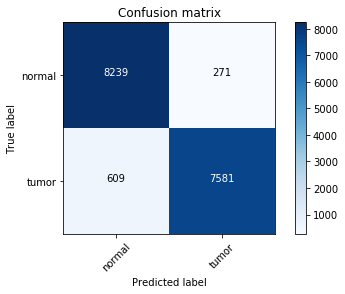

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [150]:
def plot_val_with_title(idxs, probs, title):
    def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))
    
    def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
    def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

    def plot_val_with_title(idxs, title):
        imgs = np.stack([data.val_ds[x][0] for x in idxs])
        title_probs = [probs[x] for x in idxs]
        print(title)
        return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

    def plots(ims, figsize=(12,6), rows=2, titles=None):
        f = plt.figure(figsize=figsize)
        for i in range(len(ims)):
            sp = f.add_subplot(rows, len(ims)//rows, i+1)
            sp.axis('Off')
            if titles is not None: sp.set_title(titles[i], fontsize=16)
            plt.imshow(ims[i])    
    
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=2, titles=title_probs, figsize=(16,8))

def most_by_correct(probs, preds, val_y, y, is_correct, n=8):
    """ Return the indexes of the most correct or most false predictions you have made
    
    preds: predicted y values
    val_y: true y values
    y: class we care about
    is_correct: we want to display either true values, or false ones.
    """
    mask = (preds == val_y)==is_correct & (val_y == y)        
    idxs = np.where(mask)[0]
    top_idxs = idxs[np.argsort(probs[idxs, y]*-1)[:n]]
    return top_idxs

Most Correct Normal


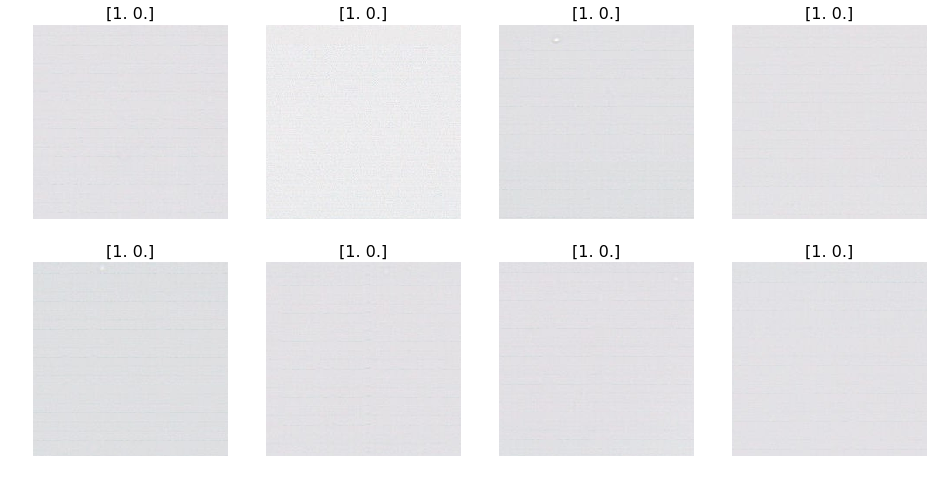

In [151]:
idxs = most_by_correct(probs, preds, data.val_y, y=0, is_correct=True, n=8)
plot_val_with_title(idxs, title='Most Correct Normal')

Most Correct Tumor


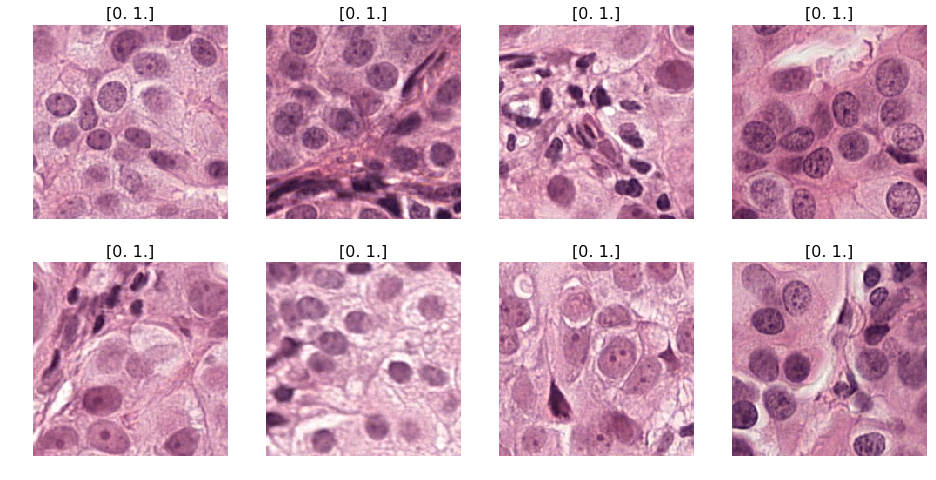

In [152]:
idxs = most_by_correct(probs, preds, data.val_y, y=1, is_correct=True, n=8)
plot_val_with_title(idxs, title='Most Correct Tumor')

Most incorrect normal


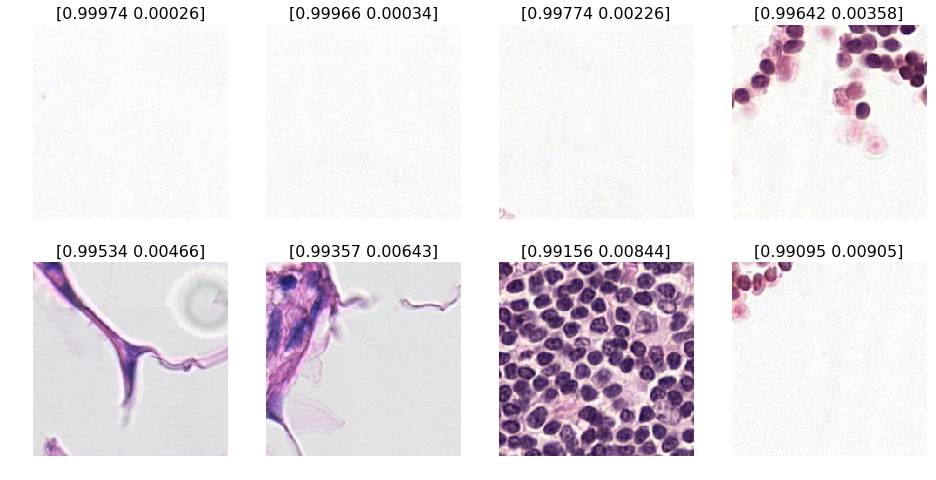

In [153]:
idxs = most_by_correct(probs, preds, data.val_y, y=0, is_correct=False, n=8)
plot_val_with_title(idxs, title='Most incorrect normal')

Most incorrect tumor


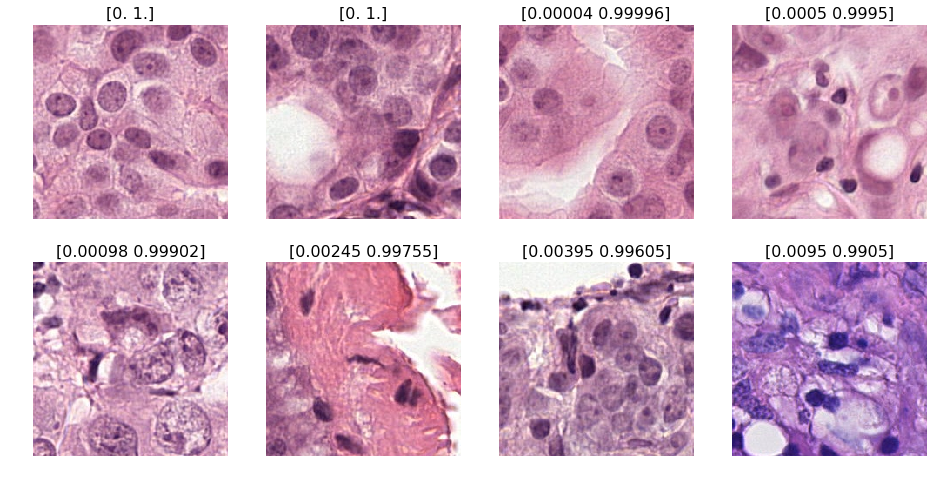

In [154]:
idxs = most_by_correct(probs, preds, data.val_y, y=1, is_correct=False, n=8)
plot_val_with_title(idxs, title='Most incorrect tumor')

The failures look like the patch selection was wrong, not the algorithm

## Test Bagging and non-bagging ResNet50

In [3]:
from other_functions import *

PATH = '/media/rene/Data/camelyon_out/global_label_tiles_224_10_strict'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*10
models_name = ['resnet50_full_'+str(i)for i in range (10)]

int_acc = bagging_ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)
x = list(range(1, 11))

plt.plot(x, int_acc)
plt.title('ResNet50 on Full Dataset')
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.show()

OSError: Is a directory: /media/rene/Data/camelyon_out/global_label_tiles_224_10_strict/valid/normal/Normal_044

## More Color Augmentation

Transforms from Detecting Cancer Metastases on Gigapixel Pathology Images:
* brightness with a maximum delta of 64/255
* saturation with a maximum delta of 0.25
* hue with a maximum delta of 0.04
* contrast with a maximum delta of 0.75

#### Train ResNet50 on the full dataset

In [37]:
import cv2
from PIL import Image

# color_transform = transforms.ColorJitter(brightness=64/255, contrast=0.75, saturation=0.25,hue=0.04)
# fastai.transforms.Transform

class TorchVisionColorJitterCopy(Transform):
    def __init__(self, brightness, contrast, saturation, hue, tfm_y=TfmType.NO):
        # what is tfm_y=TfmType.NO? I just copy from the examples
        super().__init__(tfm_y)
        self.color_transform = transforms.ColorJitter(brightness=brightness, contrast=contrast, 
                                                      saturation=saturation,hue=hue)

    def set_state(self):
        pass # the torch vision transform handles this
#         self.store.b_rand = rand0(self.b)
#         self.store.c_rand = rand0(self.c)


    def do_transform(self, x, is_y):
        # take in image, convert to pil for torchvision, then convert back to cv2
        x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
#         print('np.mean(x)', np.mean(x))
        pil_img = Image.fromarray(x.astype('uint8'))
        transformed_pil_img = self.color_transform(pil_img)
        transformed_cv2_img = np.array(transformed_pil_img)[:, :, ::-1].copy() 
#         print('np.mean(x)', np.mean(x))
        return transformed_cv2_img

In [22]:
# load train valid split
# ttv_split = np.load('/media/rene/Data/camelyon/other/ttv_split.p')
# normal_valid = ttv_split['normal_vaild_idx']
# tumor_valid = ttv_split['tumor_vaild_idx']
# normal_train = list(range(1, 161))
# normal_train = [num for num in normal_train if num not in normal_valid]
# tumor_train = list(range(1, 111))
# tumor_train = [num for num in tumor_train if num not in tumor_valid]

PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

labels_df = pd.read_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_labels.csv')

val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", "rb" ) )

### Look at this augmentation compared to previous

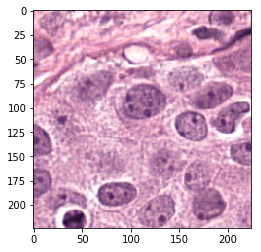

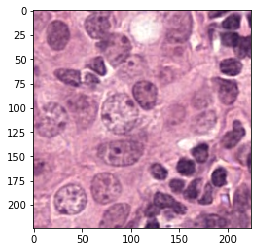

In [8]:
models_arch = resnet50
sz = 224

subset_labels_df = labels_df.sample(frac=1)
subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv',  
                            index = False)
csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv'

tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                    val_idxs=val_idxs, bs=2)

x,y=next(iter(data.trn_dl))
plt.imshow(data.trn_ds.denorm(x)[0])
plt.figure()
plt.imshow(data.trn_ds.denorm(x)[1])

(224, 224, 3)


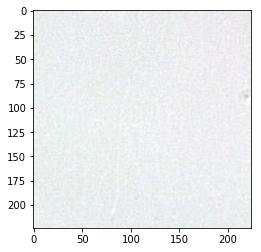

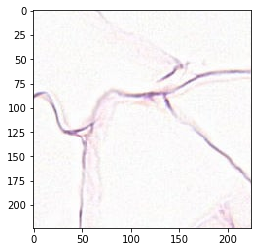

In [10]:
# vars(data.trn_ds).keys()
# print(data.trn_ds.fnames[0])
image = Image.open(data.trn_ds.fnames[0])
print(np.asarray(image).shape)
plt.imshow(image)

plt.figure()
image = Image.open(data.trn_ds.fnames[1])
plt.imshow(np.asarray(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-2.1179  -2.1179  -2.1179  ... -2.1179  -2.1179  -2.1179 ]
  [-2.1179  -2.1179  -2.1179  ... -2.1179  -2.1179  -2.1179 ]
  [-2.1179  -2.1179  -2.1179  ... -2.1179  -2.1179  -2.1179 ]
  ...
  [-2.1179  -2.1179  -2.1179  ... -2.1179  -2.1179  -2.1179 ]
  [-2.1179  -2.1179  -2.1179  ... -2.1179  -2.1179  -2.1179 ]
  [-2.1179  -2.1179  -2.1179  ... -2.1179  -2.1179  -2.1179 ]]

 [[-2.03571 -2.03571 -2.03571 ... -2.03571 -2.03571 -2.03571]
  [-2.03571 -2.03571 -2.03571 ... -2.03571 -2.03571 -2.03571]
  [-2.03571 -2.03571 -2.03571 ... -2.03571 -2.03571 -2.03571]
  ...
  [-2.03571 -2.03571 -2.03571 ... -2.03571 -2.03571 -2.03571]
  [-2.03571 -2.03571 -2.03571 ... -2.03571 -2.03571 -2.03571]
  [-2.03571 -2.03571 -2.03571 ... -2.03571 -2.03571 -2.03571]]

 [[-1.80444 -1.80444 -1.80444 ... -1.80444 -1.80444 -1.80444]
  [-1.80444 -1.80444 -1.80444 ... -1.80444 -1.80444 -1.80444]
  [-1.80444 -1.80444 -1.80444 ... -1.80444 -1.80444 -1.80444]
  ...
  [-1.80444 -1.80444 -1.80444 ... -1.80444 -1.80

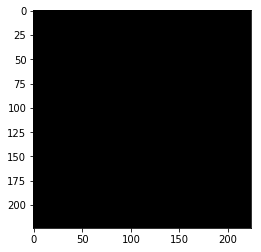

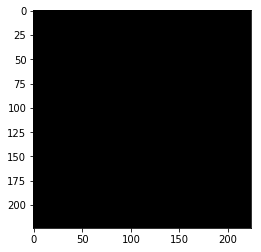

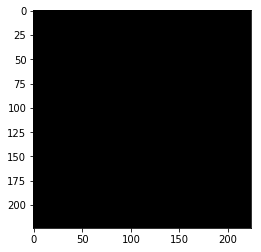

In [38]:
sz = 224
color_transform  = TorchVisionColorJitterCopy(brightness=10/255, contrast=0.05, saturation=0.05, hue=0.01)
pathology_tfms = [RandomRotate(10), RandomFlip(), RandomDihedral(), color_transform]

tfms = tfms_from_model(models_arch, sz, aug_tfms=pathology_tfms, max_zoom=1)
data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                    val_idxs=val_idxs, bs=2)

x,y=next(iter(data.trn_dl))
print(x.cpu().numpy()[0])
plt.imshow(np.swapaxes(x.cpu().numpy()[0],0,2))
plt.figure()

plt.imshow(data.trn_ds.denorm(x)[0])
plt.figure()
plt.imshow(data.trn_ds.denorm(x)[1])

In [4]:
# train on full data
models_arch = resnet50
models_name = 'resnet50'
lr=np.array([1e-3,5e-3,1e-2])
sz = 224

# color_transform  = transforms.ColorJitter(brightness=64/255, contrast=0.75, saturation=0.25,hue=0.04)
color_transform  = TorchVisionColorJitterCopy(brightness=64/255, contrast=0.75, saturation=0.25,hue=0.04)
pathology_tfms = [RandomRotate(10), RandomFlip(), RandomDihedral(), color_transform]

for i in tqdm(range(9, 10)):
    # Don't need to duplicate this, but do it to be consistent
    subset_labels_df = labels_df.sample(frac=1)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv'
    
#     # get the validation indices based on this
#     val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=pathology_tfms, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_full_all_aug_'+str(i)) # train whole model

  0%|          | 0/1 [00:00<?, ?it/s]


epoch      trn_loss   val_loss   accuracy                      
    0      0.706191   1.479701   0.595795  



epoch      trn_loss   val_loss   accuracy                      
    0      0.689102   6.95551    0.49541   
    1      0.680161   2.640411   0.49541                       
    2      0.679021   3.180164   0.49541                       
    3      0.681994   4.495913   0.49541                       
    4      0.676329   2.70079    0.49541                       
    5      0.668955   1.952657   0.495232                      
    6      0.67111    2.611253   0.49541                       

100%|██████████| 1/1 [1:22:01<00:00, 4921.10s/it]

In [ ]:
# train on full data
models_arch = resnet50
models_name = 'resnet50'
lr=np.array([1e-3,5e-3,1e-2])
sz = 224

# color_transform  = transforms.ColorJitter(brightness=64/255, contrast=0.75, saturation=0.25,hue=0.04)
color_transform  = TorchVisionColorJitterCopy(brightness=32/255, contrast=0.375, saturation=0.125, hue=0.04)
pathology_tfms = [RandomRotate(10), RandomFlip(), RandomDihedral(), color_transform]

for i in tqdm(range(10)):
    # Don't need to duplicate this, but do it to be consistent
    subset_labels_df = labels_df.sample(frac=1)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp.csv'
    
#     # get the validation indices based on this
#     val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=pathology_tfms, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_full_half_aug_'+str(i)) # train whole model

  0%|          | 0/10 [00:00<?, ?it/s]


epoch      trn_loss   val_loss   accuracy                      
    0      0.699662   0.542059   0.761741  



epoch      trn_loss   val_loss   accuracy                      
    0      0.68356    2.455503   0.495351  
    1      0.68075    3.605965   0.49541                       
    2      0.672755   2.241982   0.49772                       
    3      0.675393   2.92547    0.49541                       
 54%|█████▎    | 698/1299 [05:23<04:38,  2.16it/s, loss=0.677]